# Build a Large Language Model (from scratch)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px">

Author of notes: https://github.com/deburky

## Chapter 4: Implementing a GPT model from scratch to generate text

In [3]:
import torch
import torch.nn as nn

GPT_CONFIG_124M = {
    "vocab_size": 50_257,    # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        return self.out_head(x)

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [9]:
import tiktoken
from IPython.display import HTML
from rich import print as rprint

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.extend(
    (
        torch.tensor(tokenizer.encode(txt1)),
        torch.tensor(tokenizer.encode(txt2)),
    )
)
batch = torch.stack(batch, dim=0)
rprint(batch)

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)

display(HTML(
    """The output tensor has two rows corresponding to
    the two text samples. Each text sample consists of
    four tokens; each token is a 50,257-dimensional vector,
    which matches the size of the tokenizer's vocabulary."""
))

rprint(logits)
rprint(f"Output shape: {logits.shape}")

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)

Output shape: torch.Size([2, 4, 50257])

## Layer normalization

The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance. This adjustment speeds up the convergence to effective weights and ensures consistent, reliable training.

In GPT-2 and modern transformer architectures, layer normalization is typically applied before and after the multi-head attention module, and, as we have seen with the `DummyLayerNorm` placeholder, before the final output layer.

In [21]:
torch.manual_seed(123)
torch.set_printoptions(sci_mode=False)

batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
rprint(f"Raw layer outputs:\n\n{out}")

mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
rprint(f"Mean:\n {mean}")
rprint(f"Variance:\n {var}")

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
rprint(f"Normalized layer outputs:\n\n{out_norm}")
rprint(f"Mean:\n{mean}")
rprint(f"Variance:\n{var}")

Raw layer outputs:

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)

Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)

Normalized layer outputs:

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)

Mean:
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

Variance:
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

In [23]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
    
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
rprint(f"Mean:\n{mean}")
rprint(f"Variance:\n{var}")

Mean:
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

Variance:
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

## GELU

GELU and SwiGLU are more complex and smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively. They offer improved performance for deep learning models, unlike the simpler ReLU.

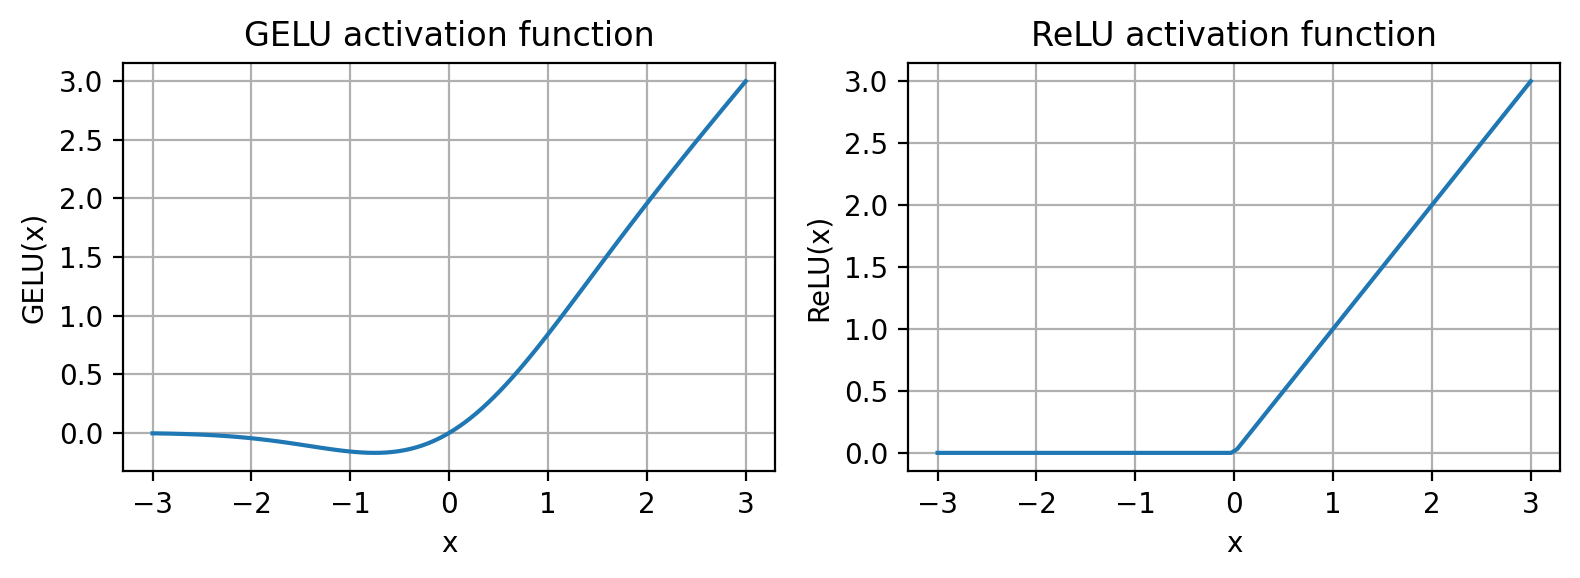

In [26]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
        
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
    
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
rprint(out.shape)

torch.Size([2, 3, 768])

## Shortcut connection

Shortcut connections are important for overcoming the limitations posed by the vanishing gradient problem in deep neural networks.

Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective training by ensuring consistent gradient flow across layers when we train the GPT model.

In [36]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [38]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## Transformer block

A transformer block combines several components, including the (masked) multi-head attention module and the `FeedForward` module. When a transformer block processes an input sequence, each element in the sequence (for example, a word or subword token) is represented by a fixed-size vector (in this case, 768 dimensions).

The operations within the transformer block, including multi-head attention and feed forward layers, are designed to transform these vectors in a way that preserves their dimensionality. While the physical dimensions of the sequence (context length and embedding size) remain unchanged as it passes through the transformer block, the content of each output vector is re-encoded to integrate contextual information from across the entire input sequence.

In [43]:
import torch

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec
    

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x
    
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

rprint(f"Input shape: {x.shape}")
rprint(f"Output shape: {output.shape}")

Input shape: torch.Size([2, 4, 768])

Output shape: torch.Size([2, 4, 768])